In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kapillondhe/american-sign-language

100% 4.63G/4.64G [02:42<00:00, 34.7MB/s]
100% 4.64G/4.64G [02:42<00:00, 30.7MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/american-sign-language.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size and target size
target_size = (256, 256)
num_classes = 29
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
               'N','Nothing','O', 'P', 'Q', 'R', 'S','Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
               ]

datagen = ImageDataGenerator(validation_split=0.1,rescale=1./255)
# Create an ImageDataGenerator for training and validation data
train_generator = datagen.flow_from_directory(
    '/content/ASL_Dataset/Train',
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    '/content/ASL_Dataset/Train',
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    subset='validation')

Found 149119 images belonging to 28 classes.
Found 16551 images belonging to 28 classes.


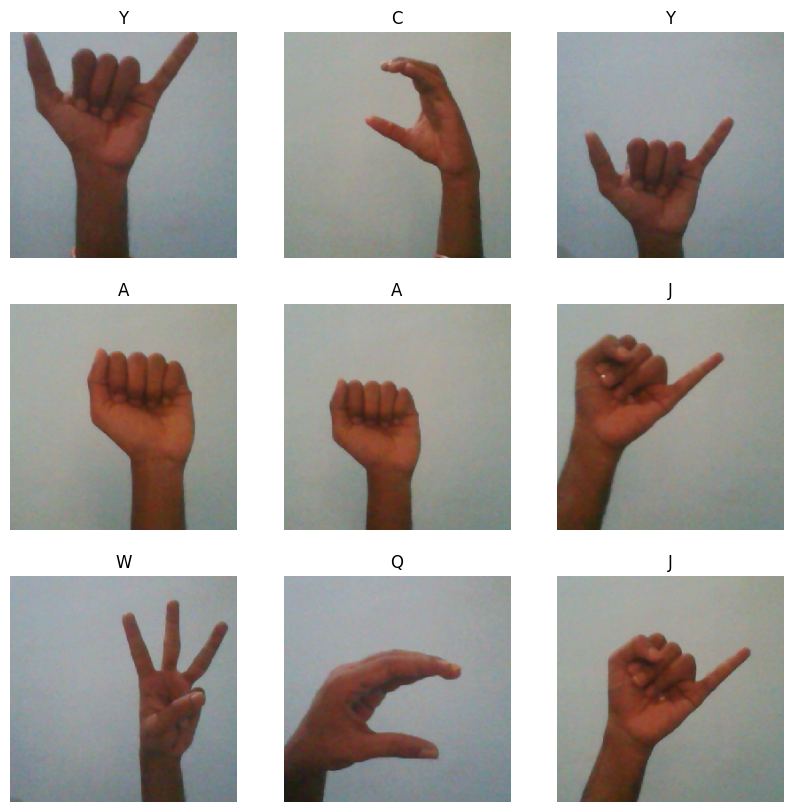

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images from the training generator
images, labels = next(val_generator)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications import VGG16


In [ ]:
#Load the VGG16 model without the top (fully connected) layers,
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3))


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable=True


In [ ]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.0005)))
model.add(Dropout(0.05))
model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.0005)))
model.add(Dropout(0.05))
model.add(Dense(16,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.0005)))
model.add(Dropout(0.05))
model.add(Dense(len(class_names),activation='softmax'))

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
callback=EarlyStopping(monitor='val_loss',min_delta=0.00001,patience=10,verbose=1,mode='auto',restore_best_weights=True)


In [ ]:
history=model.fit(train_generator,
                  validation_data=val_generator, epochs=5, batch_size=64,callbacks=callback)

Epoch 1/5
2330/2330 [==============================] - 897s 378ms/step - loss: 1.2604 - accuracy: 0.8368 - val_loss: 0.9073 - val_accuracy: 0.9350
Epoch 2/5
2330/2330 [==============================] - 854s 366ms/step - loss: 0.8667 - accuracy: 0.9304 - val_loss: 0.8657 - val_accuracy: 0.9198
Epoch 3/5
2330/2330 [==============================] - 851s 365ms/step - loss: 0.8383 - accuracy: 0.9350 - val_loss: 0.7936 - val_accuracy: 0.9423
Epoch 4/5
2330/2330 [==============================] - 852s 365ms/step - loss: 0.8227 - accuracy: 0.9377 - val_loss: 0.8291 - val_accuracy: 0.9357
Epoch 5/5
2330/2330 [==============================] - 852s 365ms/step - loss: 0.7912 - accuracy: 0.9431 - val_loss: 0.7977 - val_accuracy: 0.9326


In [ ]:
model.save('sign_detection.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications import VGG16


In [ ]:

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
DATADIR="/content/asl_alphabet_train/asl_alphabet_train"
CATEGORIES=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z','del','nothing','space']

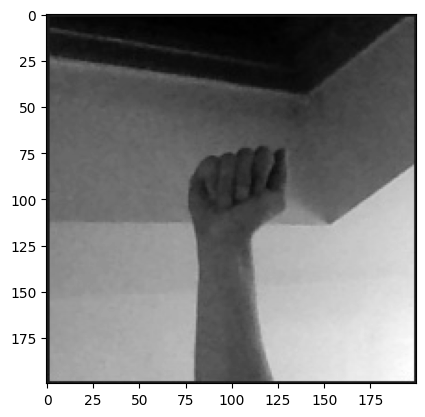

In [ ]:
for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    for image in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)     # GRAY SCALE coz rgb is 3 times bigger in size
        plt.imshow(img_array,cmap='gray')
        plt.show()
        break
    break

In [ ]:
data=[]

In [ ]:
for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    label=CATEGORIES.index(category)
    for image in os.listdir(path):
        try:
            img_array=cv2.imread(os.path.join(path,image))
            new_array=cv2.resize(img_array,(256,256))
            data.append([new_array,label])
        except Exception as e:
            pass


In [ ]:
import random
random.shuffle(data)

In [ ]:
X=[]
Y=[]
for feature,label in data:
    X.append(feature)
    Y.append(label)

In [ ]:
X=np.array(X).reshape(-1,100,100,1)
Y=np.array(Y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.2)

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

In [ ]:
plt.imshow(x_train[0])

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
#Load the VGG16 model without the top (fully connected) layers,
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3))


In [ ]:
base_model.trainable = False

In [ ]:
base_model.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable=True


In [ ]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(len(CATEGORIES),activation='softmax'))

In [ ]:

from keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(x_train, y_train,
                  validation_data=(x_test, y_test), epochs=5, batch_size=64)

In [ ]:
history=model.fit(x_train, y_train,
                  validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 100, 100, 1)


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
y_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
               'del','nothing','space']

train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/asl_alphabet_train/asl_alphabet_train',
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256)
)

Found 87000 files belonging to 29 classes.


Class Names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


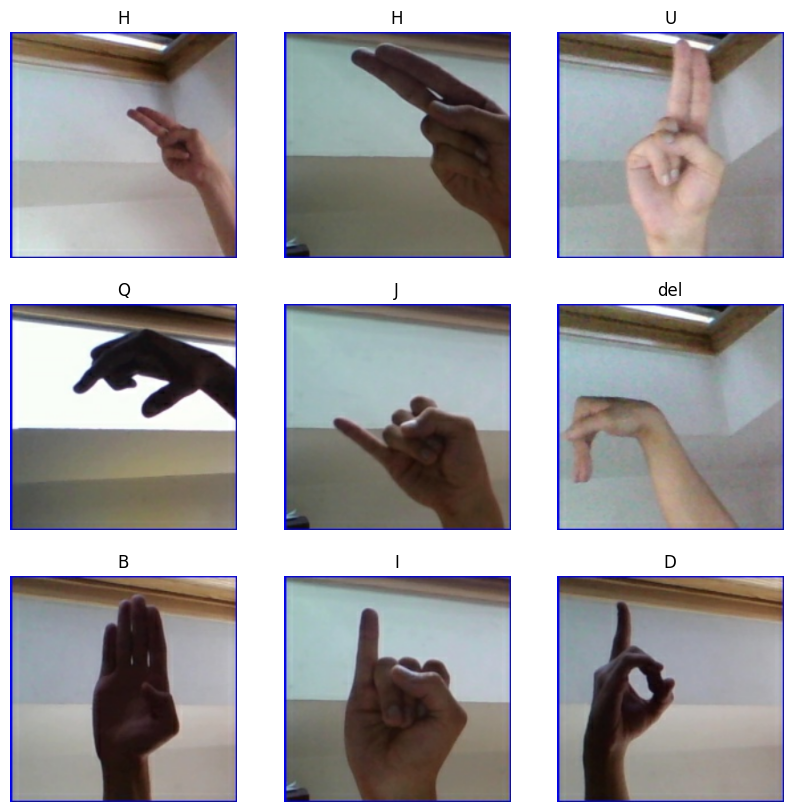

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
for images, labels in train_ds.take(1):
    # the labels contain all the labels of all the images
    #We iterate over the first batch of images and labels from the train_ds dataset using train_ds.take(1).
    # Print the class names for reference
    print("Class Names:", class_names)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ## only 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) ## remember these image should not be normalized otherwise you'll see black images
        # if you have normalized them  then do this - plt.imshow((images[i] * 255).numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
    plt.show()


In [ ]:
# normalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
normalization_layer = Rescaling(1./255)
train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
#Load the VGG16 model without the top (fully connected) layers,
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3))


In [ ]:
base_model.trainable = False

In [ ]:
base_model.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable=True


In [ ]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 29)                1885      
                                                                 
Total params: 18919261 (72.17 MB)
Trainable params: 4204573 (16.04 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history=model.fit(train_ds,epochs=5)

Epoch 1/5
2719/2719 [==============================] - 461s 166ms/step - loss: 2.3484 - accuracy: 0.4467
Epoch 2/5
2719/2719 [==============================] - 446s 164ms/step - loss: 0.9830 - accuracy: 0.7990
Epoch 3/5
2719/2719 [==============================] - 446s 164ms/step - loss: 0.5663 - accuracy: 0.8898
Epoch 4/5
2719/2719 [==============================] - 446s 164ms/step - loss: 0.3886 - accuracy: 0.9271
Epoch 5/5
2719/2719 [==============================] - 446s 164ms/step - loss: 0.2884 - accuracy: 0.9480


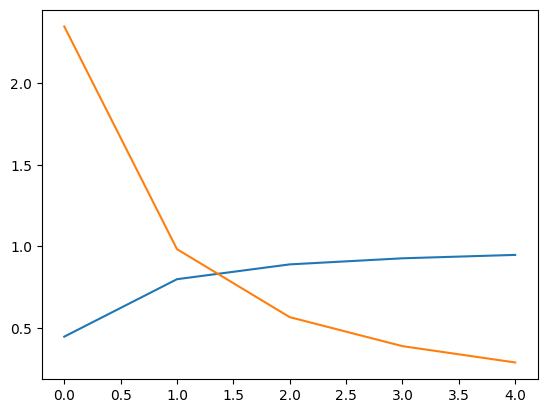

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

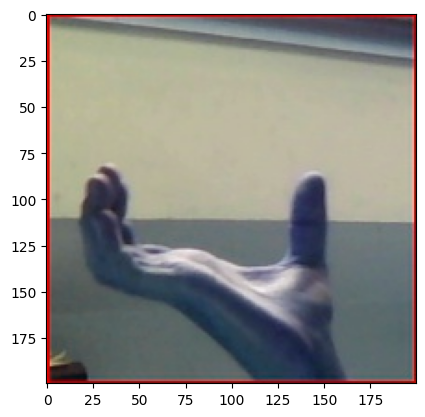

In [ ]:
import cv2
test_imag=cv2.imread('/content/asl_alphabet_test/asl_alphabet_test/space_test.jpg')
plt.imshow(test_imag)

In [ ]:
test_imag=cv2.resize(test_imag,(256,256))
model.predict(test_imag.reshape((1,256,256,3)))

1/1 [==============================] - 0s 20ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.2092434e-30, 5.6340004e-32, 0.0000000e+00,
        0.0000000e+00, 1.8250879e-36, 3.4869336e-09, 0.0000000e+00,
        1.0479283e-35, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 3.3837877e-27, 0.0000000e+00, 0.0000000e+00,
        1.6010724e-28, 1.2229225e-24, 5.6171917e-19, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00]], dtype=float32)

In [ ]:
import numpy as np
class_names[np.argmax(model.predict(test_imag.reshape((1,256,256,3))))]

1/1 [==============================] - 0s 17ms/step


'space'

In [ ]:
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(class_names),activation='softmax'))



In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds,epochs=5)

In [ ]:
history.history

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [ ]:
import cv2
test_imag=cv2.imread('/content/asl_alphabet_test/asl_alphabet_test/I_test.jpg')
plt.imshow(test_imag)

In [ ]:
test_imag=cv2.resize(test_imag,(256,256))
model.predict(test_imag.reshape((1,256,256,3)))

In [ ]:
import numpy as np
class_names[np.argmax(model.predict(test_imag.reshape((1,256,256,3))))]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size and target size
target_size = (256, 256)
num_classes = 29
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
               'N','Nothing','O', 'P', 'Q', 'R', 'S','Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
               ]

# Create an ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
test_datagen=ImageDataGenerator(
        rescale=1./255
        )
# Load and split the dataset into training and validation sets
train_generator = train_datagen.flow_from_directory(
    '/content/ASL_Dataset/Train',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    '/content/ASL_Dataset/Test',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical')
